# Forecasting with a CNN

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

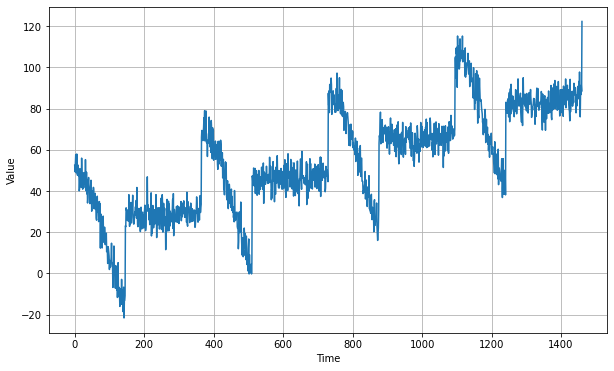

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Preprocessing With 1D-Convolutional Layers

In [5]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 8s 983ms/step - loss: 87.4947 - mae: 88.3356
Epoch 2/100
8/8 [==============================] - 1s 102ms/step - loss: 86.8595 - mae: 87.6112
Epoch 3/100
8/8 [==============================] - 1s 114ms/step - loss: 86.0590 - mae: 86.4322
Epoch 4/100
8/8 [==============================] - 1s 121ms/step - loss: 84.4441 - mae: 84.8714
Epoch 5/100
8/8 [==============================] - 1s 107ms/step - loss: 82.4501 - mae: 82.9793
Epoch 6/100
8/8 [==============================] - 1s 89ms/step - loss: 80.5387 - mae: 80.7489
Epoch 7/100
8/8 [==============================] - 1s 88ms/step - loss: 77.8250 - mae: 78.2492
Epoch 8/100
8/8 [==============================] - 1s 90ms/step - loss: 75.2095 - mae: 75.6000
Epoch 9/100
8/8 [==============================] - 1s 93ms/step - loss: 72.3287 - mae: 72.9481
Epoch 10/100
8/8 [==============================] - 1s 92ms/step - loss: 69.9495 - mae: 70.4036: 0s - loss: 70.7803 - mae: 71.
Epoch 11/100


8/8 [==============================] - 1s 79ms/step - loss: 12.1715 - mae: 12.4959
Epoch 87/100
8/8 [==============================] - 1s 81ms/step - loss: 11.7035 - mae: 13.0085
Epoch 88/100
8/8 [==============================] - 1s 77ms/step - loss: 19.7462 - mae: 19.8539
Epoch 89/100
8/8 [==============================] - 1s 96ms/step - loss: 14.5508 - mae: 14.7674
Epoch 90/100
8/8 [==============================] - 1s 95ms/step - loss: 18.0886 - mae: 18.7572
Epoch 91/100
8/8 [==============================] - 1s 84ms/step - loss: 16.8186 - mae: 17.3581
Epoch 92/100
8/8 [==============================] - 1s 77ms/step - loss: 16.4682 - mae: 16.8106
Epoch 93/100
8/8 [==============================] - 1s 77ms/step - loss: 13.9990 - mae: 14.4065
Epoch 94/100
8/8 [==============================] - 1s 81ms/step - loss: 16.8404 - mae: 17.5174
Epoch 95/100
8/8 [==============================] - 1s 97ms/step - loss: 15.0673 - mae: 15.8497
Epoch 96/100
8/8 [==============================] - 1

(1e-08, 0.0001, 0.0, 30.0)

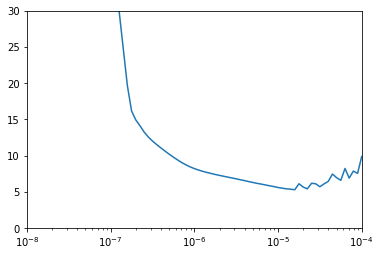

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 7s 902ms/step - loss: 57.1561 - mae: 58.2706 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
8/8 [==============================] - 1s 100ms/step - loss: 24.1624 - mae: 24.3364 - val_loss: 35.8343 - val_mae: 36.9375
Epoch 3/500
8/8 [==============================] - 1s 92ms/step - loss: 16.7320 - mae: 17.2362 - val_loss: 37.3009 - val_mae: 37.5001
Epoch 4/500
8/8 [==============================] - 1s 100ms/step - loss: 14.4453 - mae: 14.3808 - val_loss: 22.6559 - val_mae: 23.4096
Epoch 5/500
8/8 [==============================] - 1s 121ms/step - loss: 11.1129 - mae: 11.3806 - val_loss: 19.1821 - val_mae: 19.7705
Epoch 6/500
8/8 [==============================] - 1s 125ms/step - loss: 9.3560 - mae: 9.5911 - val_loss: 16.4036 - val_mae: 16.9639
Epoch 7/500
8/8 [==============================] - 1s 139ms/step - loss: 7.9507 - mae: 8.4399 - val_loss: 16.3301 - val_mae: 16.9760
Epoch 8/500
8/8 [==============================] - 1s 

Epoch 63/500
8/8 [==============================] - 1s 96ms/step - loss: 4.5503 - mae: 5.0345 - val_loss: 6.3712 - val_mae: 6.8058
Epoch 64/500
8/8 [==============================] - 1s 99ms/step - loss: 4.5790 - mae: 5.0455 - val_loss: 5.8943 - val_mae: 6.3870
Epoch 65/500
8/8 [==============================] - 1s 95ms/step - loss: 4.5457 - mae: 5.0481 - val_loss: 6.5517 - val_mae: 7.0594
Epoch 66/500
8/8 [==============================] - 1s 99ms/step - loss: 4.5951 - mae: 5.0905 - val_loss: 7.5457 - val_mae: 8.1648
Epoch 67/500
8/8 [==============================] - 1s 97ms/step - loss: 4.6111 - mae: 5.0704 - val_loss: 7.1910 - val_mae: 7.7066
Epoch 68/500
8/8 [==============================] - 1s 96ms/step - loss: 4.6212 - mae: 5.0938 - val_loss: 7.0039 - val_mae: 7.5158
Epoch 69/500
8/8 [==============================] - 1s 102ms/step - loss: 4.7077 - mae: 5.1424 - val_loss: 5.8160 - val_mae: 6.2996
Epoch 70/500
8/8 [==============================] - 1s 108ms/step - loss: 4.6083 -

Epoch 125/500
8/8 [==============================] - 1s 103ms/step - loss: 4.3230 - mae: 4.8193 - val_loss: 5.7436 - val_mae: 6.2057
Epoch 126/500
8/8 [==============================] - 1s 109ms/step - loss: 4.3493 - mae: 4.8091 - val_loss: 5.4345 - val_mae: 5.9733
Epoch 127/500
8/8 [==============================] - 1s 119ms/step - loss: 4.3952 - mae: 4.8534 - val_loss: 6.9325 - val_mae: 7.4189
Epoch 128/500
8/8 [==============================] - 1s 126ms/step - loss: 4.4707 - mae: 4.9392 - val_loss: 5.3471 - val_mae: 5.8686
Epoch 129/500
8/8 [==============================] - 1s 103ms/step - loss: 4.4592 - mae: 4.9100 - val_loss: 5.8288 - val_mae: 6.3441
Epoch 130/500
8/8 [==============================] - 1s 103ms/step - loss: 4.3211 - mae: 4.7940 - val_loss: 5.6153 - val_mae: 6.0756
Epoch 131/500
8/8 [==============================] - 1s 104ms/step - loss: 4.3456 - mae: 4.8027 - val_loss: 5.5813 - val_mae: 6.0900
Epoch 132/500
8/8 [==============================] - 1s 101ms/step - 

8/8 [==============================] - 1s 116ms/step - loss: 4.2410 - mae: 4.6966 - val_loss: 5.1991 - val_mae: 5.6941
Epoch 187/500
8/8 [==============================] - 1s 98ms/step - loss: 4.2128 - mae: 4.7158 - val_loss: 6.1154 - val_mae: 6.5764
Epoch 188/500
8/8 [==============================] - 1s 99ms/step - loss: 4.2595 - mae: 4.7305 - val_loss: 5.7742 - val_mae: 6.3041
Epoch 189/500
8/8 [==============================] - 1s 101ms/step - loss: 4.1816 - mae: 4.6953 - val_loss: 5.1922 - val_mae: 5.6449
Epoch 190/500
8/8 [==============================] - 1s 100ms/step - loss: 4.2583 - mae: 4.7114 - val_loss: 5.7618 - val_mae: 6.2214
Epoch 191/500
8/8 [==============================] - 1s 101ms/step - loss: 4.2176 - mae: 4.7047 - val_loss: 5.8366 - val_mae: 6.2455
Epoch 192/500
8/8 [==============================] - 1s 100ms/step - loss: 4.2353 - mae: 4.6894 - val_loss: 5.6554 - val_mae: 6.1457
Epoch 193/500
8/8 [==============================] - 1s 102ms/step - loss: 4.2713 - m

Epoch 248/500
8/8 [==============================] - 1s 94ms/step - loss: 4.1750 - mae: 4.6364 - val_loss: 5.5028 - val_mae: 5.9632
Epoch 249/500
8/8 [==============================] - 1s 93ms/step - loss: 4.1836 - mae: 4.6552 - val_loss: 5.0567 - val_mae: 5.4977
Epoch 250/500
8/8 [==============================] - 1s 92ms/step - loss: 4.1473 - mae: 4.6421 - val_loss: 5.4022 - val_mae: 5.9065
Epoch 251/500
8/8 [==============================] - 1s 95ms/step - loss: 4.1609 - mae: 4.6533 - val_loss: 5.0876 - val_mae: 5.6834
Epoch 252/500
8/8 [==============================] - 1s 93ms/step - loss: 4.1342 - mae: 4.6260 - val_loss: 4.9954 - val_mae: 5.4634
Epoch 253/500
8/8 [==============================] - 1s 92ms/step - loss: 4.1937 - mae: 4.6584 - val_loss: 5.2853 - val_mae: 5.7689
Epoch 254/500
8/8 [==============================] - 1s 93ms/step - loss: 4.1756 - mae: 4.6411 - val_loss: 5.5140 - val_mae: 6.0948
Epoch 255/500
8/8 [==============================] - 1s 92ms/step - loss: 4.

8/8 [==============================] - 1s 92ms/step - loss: 4.1773 - mae: 4.6606 - val_loss: 5.3515 - val_mae: 5.8167
Epoch 311/500
8/8 [==============================] - 1s 95ms/step - loss: 4.1692 - mae: 4.6395 - val_loss: 5.1147 - val_mae: 5.6230
Epoch 312/500
8/8 [==============================] - 1s 93ms/step - loss: 4.1183 - mae: 4.5850 - val_loss: 5.5792 - val_mae: 6.0627
Epoch 313/500
8/8 [==============================] - 1s 94ms/step - loss: 4.1492 - mae: 4.6450 - val_loss: 5.1216 - val_mae: 5.5799
Epoch 314/500
8/8 [==============================] - 1s 94ms/step - loss: 4.3616 - mae: 4.8000 - val_loss: 6.4550 - val_mae: 6.8667
Epoch 315/500
8/8 [==============================] - 1s 93ms/step - loss: 4.2341 - mae: 4.7060 - val_loss: 5.1062 - val_mae: 5.5136
Epoch 316/500
8/8 [==============================] - 1s 92ms/step - loss: 4.1610 - mae: 4.6036 - val_loss: 5.3269 - val_mae: 5.7605
Epoch 317/500
8/8 [==============================] - 1s 95ms/step - loss: 4.1066 - mae: 4.

8/8 [==============================] - 1s 96ms/step - loss: 4.1154 - mae: 4.5765 - val_loss: 5.2996 - val_mae: 5.7870
Epoch 373/500
8/8 [==============================] - 1s 93ms/step - loss: 4.1030 - mae: 4.5653 - val_loss: 4.8608 - val_mae: 5.3342
Epoch 374/500
8/8 [==============================] - 1s 94ms/step - loss: 4.1739 - mae: 4.6117 - val_loss: 5.1952 - val_mae: 5.7162
Epoch 375/500
8/8 [==============================] - 1s 90ms/step - loss: 4.1349 - mae: 4.6291 - val_loss: 5.2423 - val_mae: 5.7230
Epoch 376/500
8/8 [==============================] - 1s 93ms/step - loss: 4.1501 - mae: 4.6416 - val_loss: 5.3673 - val_mae: 5.8814
Epoch 377/500
8/8 [==============================] - 1s 95ms/step - loss: 4.1491 - mae: 4.6475 - val_loss: 5.0779 - val_mae: 5.5716
Epoch 378/500
8/8 [==============================] - 1s 91ms/step - loss: 4.1693 - mae: 4.6626 - val_loss: 6.3033 - val_mae: 6.7576
Epoch 379/500
8/8 [==============================] - 1s 93ms/step - loss: 4.1684 - mae: 4.

8/8 [==============================] - 1s 95ms/step - loss: 4.0131 - mae: 4.5115 - val_loss: 4.9485 - val_mae: 5.4347
Epoch 435/500
8/8 [==============================] - 1s 93ms/step - loss: 4.0565 - mae: 4.5155 - val_loss: 4.9831 - val_mae: 5.4435
Epoch 436/500
8/8 [==============================] - 1s 95ms/step - loss: 4.0484 - mae: 4.5062 - val_loss: 4.7256 - val_mae: 5.2578
Epoch 437/500
8/8 [==============================] - 1s 94ms/step - loss: 4.0322 - mae: 4.5133 - val_loss: 5.4411 - val_mae: 5.9576
Epoch 438/500
8/8 [==============================] - 1s 91ms/step - loss: 4.0725 - mae: 4.5457 - val_loss: 5.3897 - val_mae: 5.8736
Epoch 439/500
8/8 [==============================] - 1s 93ms/step - loss: 4.0692 - mae: 4.5160 - val_loss: 4.8250 - val_mae: 5.3313
Epoch 440/500
8/8 [==============================] - 1s 91ms/step - loss: 4.0427 - mae: 4.5090 - val_loss: 5.2195 - val_mae: 5.7351
Epoch 441/500
8/8 [==============================] - 1s 92ms/step - loss: 4.1238 - mae: 4.

8/8 [==============================] - 1s 95ms/step - loss: 4.0216 - mae: 4.4811 - val_loss: 4.8269 - val_mae: 5.3213
Epoch 497/500
8/8 [==============================] - 1s 92ms/step - loss: 3.9929 - mae: 4.4795 - val_loss: 5.2248 - val_mae: 5.7162
Epoch 498/500
8/8 [==============================] - 1s 91ms/step - loss: 4.0425 - mae: 4.5141 - val_loss: 5.5165 - val_mae: 5.9868
Epoch 499/500
8/8 [==============================] - 1s 94ms/step - loss: 4.0543 - mae: 4.5274 - val_loss: 5.4968 - val_mae: 5.9864
Epoch 500/500
8/8 [==============================] - 1s 94ms/step - loss: 4.0619 - mae: 4.5567 - val_loss: 5.7895 - val_mae: 6.2931


In [8]:
model = keras.models.load_model("my_checkpoint.h5")

In [9]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

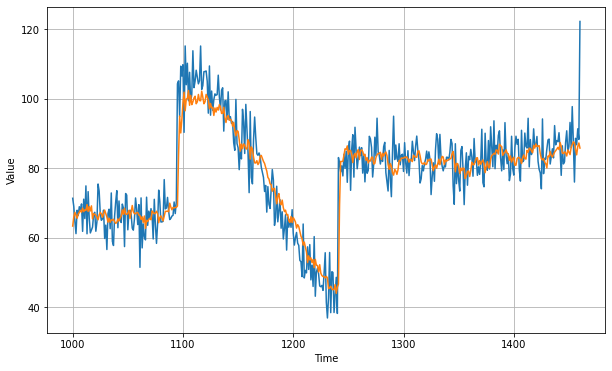

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [11]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

4.875082

## Fully Convolutional Forecasting

In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 3s 358ms/step - loss: 42.1616 - mae: 42.7348
Epoch 2/100
8/8 [==============================] - 1s 98ms/step - loss: 41.8518 - mae: 42.3290
Epoch 3/100
8/8 [==============================] - 1s 97ms/step - loss: 41.5584 - mae: 41.9344
Epoch 4/100
8/8 [==============================] - 1s 96ms/step - loss: 41.1315 - mae: 41.5100
Epoch 5/100
8/8 [==============================] - 1s 97ms/step - loss: 40.6201 - mae: 40.9796
Epoch 6/100
8/8 [==============================] - 1s 103ms/step - loss: 39.4540 - mae: 40.2333
Epoch 7/100
8/8 [==============================] - 1s 105ms/step - loss: 38.7233 - mae: 39.1041
Epoch 8/100
8/8 [==============================] - 1s 95ms/step - loss: 36.6903 - mae: 37.1633
Epoch 9/100
8/8 [==============================] - 1s 99ms/step - loss: 33.4870 - mae: 33.8624
Epoch 10/100
8/8 [==============================] - 1s 97ms/step - loss: 28.0736 - mae: 28.4693
Epoch 11/100
8/8 [============================

8/8 [==============================] - 1s 96ms/step - loss: 105.5807 - mae: 103.7601
Epoch 88/100
8/8 [==============================] - 1s 94ms/step - loss: 78.6988 - mae: 77.6527
Epoch 89/100
8/8 [==============================] - 1s 94ms/step - loss: 107.6347 - mae: 105.5650
Epoch 90/100
8/8 [==============================] - 1s 95ms/step - loss: 42.5124 - mae: 42.7224
Epoch 91/100
8/8 [==============================] - 1s 96ms/step - loss: 148.3065 - mae: 144.6998
Epoch 92/100
8/8 [==============================] - 1s 94ms/step - loss: 35.6890 - mae: 36.1479
Epoch 93/100
8/8 [==============================] - 1s 94ms/step - loss: 34.5188 - mae: 34.9346
Epoch 94/100
8/8 [==============================] - 1s 94ms/step - loss: 33.2421 - mae: 33.6531
Epoch 95/100
8/8 [==============================] - 1s 96ms/step - loss: 31.7019 - mae: 32.2861
Epoch 96/100
8/8 [==============================] - 1s 94ms/step - loss: 30.3908 - mae: 30.8646
Epoch 97/100
8/8 [=============================

(0.0001, 0.1, 0.0, 30.0)

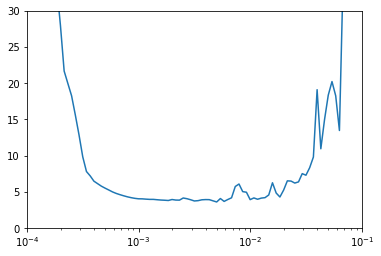

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32): # this is wavenet
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 3s 391ms/step - loss: 40.0589 - mae: 40.6938 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
8/8 [==============================] - 1s 125ms/step - loss: 38.2967 - mae: 38.6062 - val_loss: 68.0121 - val_mae: 68.4613
Epoch 3/500
8/8 [==============================] - 1s 121ms/step - loss: 35.0624 - mae: 35.5927 - val_loss: 60.6271 - val_mae: 61.3196
Epoch 4/500
8/8 [==============================] - 1s 126ms/step - loss: 31.5355 - mae: 31.3079 - val_loss: 50.3134 - val_mae: 50.6322
Epoch 5/500
8/8 [==============================] - 1s 126ms/step - loss: 25.5509 - mae: 25.4281 - val_loss: 36.3013 - val_mae: 37.1148
Epoch 6/500
8/8 [==============================] - 1s 121ms/step - loss: 20.4346 - mae: 20.6456 - val_loss: 31.7196 - val_mae: 32.5077
Epoch 7/500
8/8 [==============================] - 1s 123ms/step - loss: 18.9350 - mae: 19.3888 - val_loss: 29.5587 - val_mae: 30.5285
Epoch 8/500
8/8 [==============================] 

Epoch 63/500
8/8 [==============================] - 1s 117ms/step - loss: 3.7807 - mae: 4.2592 - val_loss: 4.2718 - val_mae: 4.7481
Epoch 64/500
8/8 [==============================] - 1s 120ms/step - loss: 3.7845 - mae: 4.2509 - val_loss: 4.2234 - val_mae: 4.7229
Epoch 65/500
8/8 [==============================] - 1s 120ms/step - loss: 3.7686 - mae: 4.2454 - val_loss: 4.2517 - val_mae: 4.7220
Epoch 66/500
8/8 [==============================] - 1s 123ms/step - loss: 3.7727 - mae: 4.2407 - val_loss: 4.1978 - val_mae: 4.7242
Epoch 67/500
8/8 [==============================] - 1s 117ms/step - loss: 3.7675 - mae: 4.2354 - val_loss: 4.3499 - val_mae: 4.8060
Epoch 68/500
8/8 [==============================] - 1s 117ms/step - loss: 3.7591 - mae: 4.2346 - val_loss: 4.2496 - val_mae: 4.7139
Epoch 69/500
8/8 [==============================] - 1s 115ms/step - loss: 3.7552 - mae: 4.2233 - val_loss: 4.2837 - val_mae: 4.7247
Epoch 70/500
8/8 [==============================] - 1s 118ms/step - loss: 3.

Epoch 125/500
8/8 [==============================] - 1s 116ms/step - loss: 3.4767 - mae: 3.9267 - val_loss: 4.2494 - val_mae: 4.7419
Epoch 126/500
8/8 [==============================] - 1s 116ms/step - loss: 3.4549 - mae: 3.9235 - val_loss: 4.2002 - val_mae: 4.7246
Epoch 127/500
8/8 [==============================] - 1s 118ms/step - loss: 3.4478 - mae: 3.9216 - val_loss: 4.2196 - val_mae: 4.7150
Epoch 128/500
8/8 [==============================] - 1s 118ms/step - loss: 3.4766 - mae: 3.9177 - val_loss: 4.4013 - val_mae: 4.8623
Epoch 129/500
8/8 [==============================] - 1s 117ms/step - loss: 3.4463 - mae: 3.9156 - val_loss: 4.2753 - val_mae: 4.7848
Epoch 130/500
8/8 [==============================] - 1s 117ms/step - loss: 3.4511 - mae: 3.9088 - val_loss: 4.2029 - val_mae: 4.7302
Epoch 131/500
8/8 [==============================] - 1s 116ms/step - loss: 3.4587 - mae: 3.9058 - val_loss: 4.2512 - val_mae: 4.7301
Epoch 132/500
8/8 [==============================] - 1s 117ms/step - 

In [15]:
model = keras.models.load_model("my_checkpoint.h5")

In [16]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

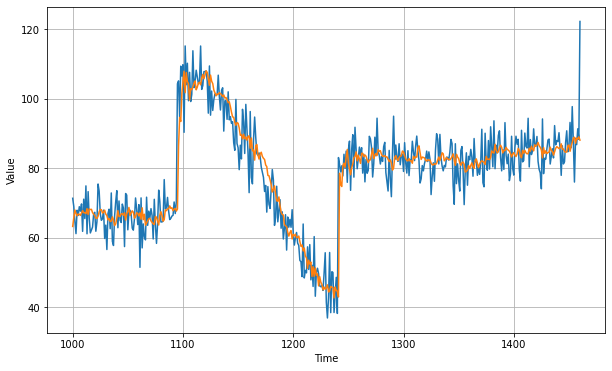

In [17]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [18]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.5747375